In [39]:
# 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install ipywidgets

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.19.2
    Uninstalling transformers-4.19.2:
      Successfully uninstalled transformers-4.19.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kobert 0.2.3 requires transformers>=4.8.1, but you have transformers 3.0.2 which is incompatible.


In [40]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-37gv45uf
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-37gv45uf
  Using cached transformers-4.19.2-py3-none-any.whl (4.2 MB)
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.8.1rc1
    Uninstalling tokenizers-0.8.1rc1:
      Successfully uninstalled tokenizers-0.8.1rc1
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2


In [41]:
# 라이브러리 호출
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#GPU 사용 시
device = torch.device('cuda')

In [42]:
# 감정분류 데이터셋
chatbot_data = pd.read_excel('한국어_단발성_대화_데이터셋.xlsx')

In [43]:
# 7개 감정 class 숫자에 대응
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [44]:
# 입력 데이터셋 토큰화
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [45]:
# 파라미터 세팅
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [46]:
# 훈련,테스트셋 분류
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [47]:
# model, tokenizer, vocab 설정
from kobert.utils import get_tokenizer

bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [48]:
# tokenization, int encoding, padding 진행
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

In [49]:
# torch형식의 데이터셋 형성
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [51]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [52]:
# kobert 모델 학습
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

  0%|          | 0/483 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0392513275146484 train acc 0.140625
epoch 1 batch id 201 loss 1.537391185760498 train acc 0.2814832089552239
epoch 1 batch id 401 loss 1.3167170286178589 train acc 0.38088372817955113
epoch 1 train acc 0.40178092170845797


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 1 test acc 0.5204823585505404


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.3538732528686523 train acc 0.5
epoch 2 batch id 201 loss 1.1874582767486572 train acc 0.5264303482587065
epoch 2 batch id 401 loss 1.0436365604400635 train acc 0.5605517456359103
epoch 2 train acc 0.5698290487692661


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 2 test acc 0.5332565162110617


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.125349760055542 train acc 0.546875
epoch 3 batch id 201 loss 1.1165132522583008 train acc 0.6293532338308457
epoch 3 batch id 401 loss 0.825697124004364 train acc 0.6580034289276808
epoch 3 train acc 0.666991363775784


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 3 test acc 0.545994251960161


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.8717546463012695 train acc 0.703125
epoch 4 batch id 201 loss 0.8473079800605774 train acc 0.7182058457711443
epoch 4 batch id 401 loss 0.601282000541687 train acc 0.7429083541147132
epoch 4 train acc 0.7484160532167778


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 4 test acc 0.5499145740623014


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6968972682952881 train acc 0.75
epoch 5 batch id 201 loss 0.5951226949691772 train acc 0.7816386815920398
epoch 5 batch id 401 loss 0.49279510974884033 train acc 0.7978880922693267
epoch 5 train acc 0.799997364082509


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 5 test acc 0.5534839213816487


In [53]:
loss = pd.DataFrame({'loss': [0.6906728148460388,0.6954085230827332,0.5235905647277832,0.6604369878768921,0.6515017151832581,0.5543966889381409,
                              0.6424657702445984,0.6376284956932068,0.5693572759628296,0.40426892042160034,0.5116267204284668,0.5966740846633911,
                              0.4012373089790344,0.5867453217506409,0.519186794757843,0.3935793340206146,0.4689515233039856,0.3157631754875183,
                              0.41080811619758606,0.40170037746429443,0.2948821187019348,0.1348014920949936,0.24904046952724457,0.14609594643115997,
                              0.1253548115491867,0.2120804786682129,0.13995850086212158,0.03900345042347908,0.1405675709247589,0.1392030119895935]
            })
train_acc = pd.DataFrame({'train_acc': [0.809237453032743,0.8096903515834676,0.8233743577946477,0.8378587244076375,0.8565365961199295,0.8844341883291159,
                                        0.9254334886128365,0.9605654761904762,0.9774521221532091,0.982292625182118]
            })
test_acc = pd.DataFrame({'test_acc': [0.5448883502860776,0.5352497880906972,0.5308957141343504,0.5218200360245815,0.5070890283958466,0.5174196069082433,
                                      0.5184990199194744,0.533948532528078,0.5394184414070777,0.5301209207459208]
            })

In [54]:
train_acc = train_acc*100

In [55]:
test_acc = test_acc*100

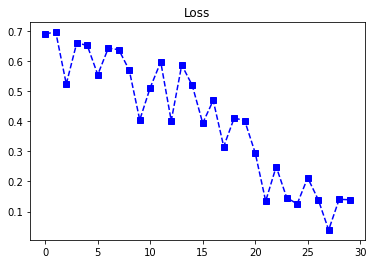

In [56]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(loss,'bs--')
plt.show()

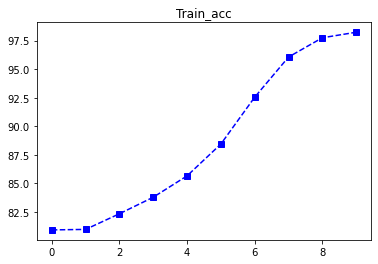

In [57]:
plt.title('Train_acc')
plt.plot(train_acc,'bs--')
plt.show()

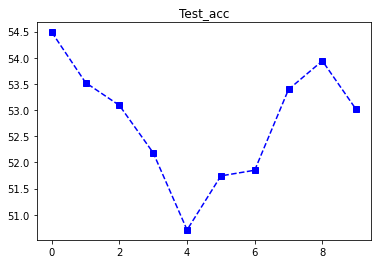

In [58]:
plt.title('Test_acc')
plt.plot(test_acc,'bs--')
plt.show()

In [59]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람")
            elif np.argmax(logits) == 2:
                test_eval.append("분노")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 4:
                test_eval.append("중립")
            elif np.argmax(logits) == 5:
                test_eval.append("행복")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오")

    return test_eval[0]

In [60]:
# 리그오브레전드 트윗 데이터셋
def emotion(list_name):
  name_csv = pd.read_csv(list_name)
  name_csv['emotion'] = name_csv['full_text'].apply(predict)
  return name_csv

In [81]:
keyword = pd.DataFrame({'full_text' : ['직장인', '체스', '토너먼트 레전드', '인기 교류', '시기 무리', '적수 공포', '광기 살육', '틈새시장', '레전드 욕구', '업무', '워치 리듬', '대회 생방송', '게이머', '워크래프트 철권', '시뮬레이션', '경기 재훈', '게임 레인보우', '스포츠선수', '시즌 경험', '스포츠', '컨트롤 인기', '이스포츠', '컴퓨터', '오늘 게임', '메인 게임', '공포 축구', '스포츠 페스티벌', '경기', '최대 경기', '체스 리그', '레전드 스포츠선수', '재미 사회생활', '스포츠 종목', '온라인 자택', '리듬 게임', '해설 컴퓨터', '성인 남성', '이스포츠 영향', '다른 게임', '경기 시간', '틈새시장 나름', '프로 경기', '인수 라이엇게임즈', '선수단 운영', '무리 남자', '비디오 게임', '레전드 경기', '경기 스포츠', '롤토 체스', '전반 이스포츠', '진행 게임', '로란 워크래프트', '게임 리그', '이스포츠 종주국', '하필 스포츠', '전략 게임', '라이엇게임즈', '게임 개발', '게임 배틀', '합성어 게임', '매니아 입문', '게임 주말', '스포츠선수 소리', '워크래프트', '게임 가능', '온라인 배틀', '출현 게임', '헛소리 게임', '라이엇 게임', '시뮬레이션 게임', '지식 플레이', '국산 게임', '레전드 게임', '게임', '프로게임단 협업', '프로게임단 프로게임단', '서브 게임', '프로게임단', '성공 게이머', '게임 사가', '게임 형식', '생각 이스포츠', '게임 에이펙', '게임 서코', '게임 월드', '인기 게임', '게임 사이', '멀티플레이어 온라인', '게임 해설', '게임 대회', '게임 위주', '여러가지 게임', '게임 시간대', '게임 명의', '운영 프로게임단', '요즘 경기', '남성 게임', '망겜 게임', '게임 직장인', '직장인 게임']})

In [82]:
keyword.to_csv('keyword_emotion.csv')

In [83]:
total_emotion = emotion('//content//keyword_emotion.csv')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [86]:
total_emotion.to_csv('keyword_emotion.csv')

In [87]:
total_emotion

,Unnamed: 0,full_text,emotion
0,0,직장인,슬픔
1,1,체스,놀람
2,2,토너먼트 레전드,행복
3,3,인기 교류,행복
4,4,시기 무리,중립
...,...,...,...
95,95,요즘 경기,행복
96,96,남성 게임,중립
97,97,망겜 게임,혐오
98,98,게임 직장인,슬픔


In [ ]:
top_emotion = emotion('top_list.csv')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
mid_emotion = emotion('mid_list.csv')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
jungle_emotion = emotion('jungle_list.csv')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
ad_emotion = emotion('ad_list.csv')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sup_emotion = emotion('sup_list.csv')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
total_emotion.to_csv('total_emotion.csv')
top_emotion.to_csv('top_emotion.csv')
mid_emotion.to_csv('mid_emotion.csv')
jungle_emotion.to_csv('jungle_emotion.csv')
ad_emotion.to_csv('ad_emotion.csv')
sup_emotion.to_csv('sup_emotion.csv')

In [ ]:
total_emotion